# Clustering the Polar Bears


In [1]:
# !pip install haversine
# !pip install rioxarray

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from haversine import haversine, Unit
from ipyleaflet import Map, Marker, MarkerCluster, basemaps, basemap_to_tiles
from ipywidgets import HTML
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from warnings import filterwarnings

filterwarnings('ignore')

## Load data

In [3]:
# Load the data into a pandas dataframe
df_raw = pd.read_csv("../data/raw/polarBear_CTCRWlocations_chukchiBeaufort_1985-2017.csv")
df_raw.head()

,UniqueAnimalID,timestamp,mu_lat,mu_lon,se_mu_x,se_mu_y
0,1,7/1/1986 0:00,69.7687,-141.3759,14589,14589
1,1,7/1/1986 6:00,69.7703,-141.3863,12248,12248
2,1,7/1/1986 12:00,69.7718,-141.3942,9375,9375
3,1,7/1/1986 18:00,69.7730,-141.3960,5835,5835
4,1,7/2/1986 0:00,69.7738,-141.3834,2517,2517


In [4]:
df_raw[df_raw.UniqueAnimalID == 311]

,UniqueAnimalID,timestamp,mu_lat,mu_lon,se_mu_x,se_mu_y
196864,311,7/1/2013 0:00,70.5648,-135.9348,31,31
196865,311,7/1/2013 6:00,70.5822,-136.0121,30,30
196866,311,7/1/2013 12:00,70.4862,-136.0627,30,30
196867,311,7/1/2013 18:00,70.4714,-136.2293,30,30
196868,311,7/2/2013 0:00,70.4720,-136.4244,30,30
...,...,...,...,...,...,...
197471,311,11/29/2013 18:00,70.9056,-152.4745,30,30
197472,311,11/30/2013 0:00,70.9069,-152.4838,30,30
197473,311,11/30/2013 6:00,70.9030,-152.4552,30,30
197474,311,11/30/2013 12:00,70.8915,-152.3489,30,30


In [5]:
df_raw.shape

(338413, 6)

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338413 entries, 0 to 338412
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   UniqueAnimalID  338413 non-null  int64  
 1   timestamp       338413 non-null  object 
 2   mu_lat          338413 non-null  float64
 3   mu_lon          338413 non-null  float64
 4   se_mu_x         338413 non-null  int64  
 5   se_mu_y         338413 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 15.5+ MB


In [7]:
df_raw.describe()

,UniqueAnimalID,mu_lat,mu_lon,se_mu_x,se_mu_y
count,338413.000000,338413.000000,338413.000000,338413.000000,338413.000000
mean,261.228664,72.380540,-114.949210,10146.473454,10146.473454
std,151.938359,2.190199,107.879343,8804.758996,8804.758996
min,1.000000,63.383000,-179.999900,11.000000,11.000000
25%,124.000000,70.892100,-163.503400,2697.000000,2697.000000
50%,280.000000,71.913600,-149.778200,8513.000000,8513.000000
75%,375.000000,73.505800,-140.424300,15010.000000,15010.000000
max,541.000000,83.901400,179.999800,66766.000000,66766.000000


In [8]:
df_raw.nunique()

UniqueAnimalID       406
timestamp          18972
mu_lat             86166
mu_lon            249455
se_mu_x            35792
se_mu_y            35792
dtype: int64

## Filtering out extreme values or missing data

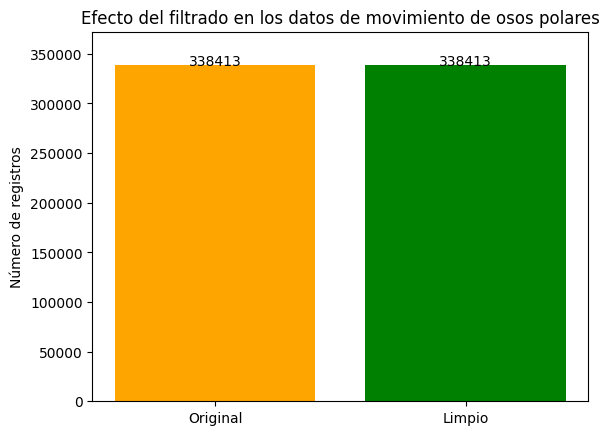

In [9]:
n_total = len(df_raw)

# Limpieza
df_clean = df_raw.dropna(subset=["mu_lat", "mu_lon", "timestamp"])
df_clean = df_clean[
    (df_clean["mu_lat"] > -90) & (df_clean["mu_lat"] < 90) &
    (df_clean["mu_lon"] > -180) & (df_clean["mu_lon"] < 180)
]
df_clean["timestamp"] = pd.to_datetime(df_clean["timestamp"], errors="coerce")
df_clean = df_clean.dropna(subset=["timestamp"])

n_clean = len(df_clean)

# Gráfico
plt.bar(["Original", "Limpio"], [n_total, n_clean], color=["orange", "green"])
plt.ylabel("Número de registros")
plt.title("Efecto del filtrado en los datos de movimiento de osos polares")
plt.text(0, n_total + 10, f"{n_total}", ha="center")
plt.text(1, n_clean + 10, f"{n_clean}", ha="center")
plt.ylim(0, n_total * 1.1)
plt.show()


In [10]:
df_raw.isnull().sum()

UniqueAnimalID    0
timestamp         0
mu_lat            0
mu_lon            0
se_mu_x           0
se_mu_y           0
dtype: int64

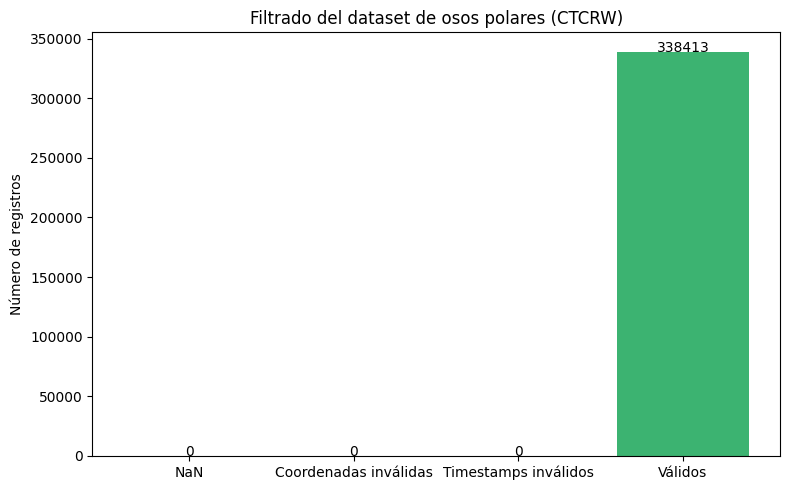

In [11]:
# Copia del DataFrame original
df_raw = df_raw.copy()

# Conteo inicial
n_total = len(df_raw)
descartes = {}

# 1. NaNs en coordenadas o timestamp
mask_nan = df_raw["mu_lat"].isna() | df_raw["mu_lon"].isna() | df_raw["timestamp"].isna()
descartes["NaN"] = mask_nan.sum()
df_raw = df_raw[~mask_nan]

# 2. Coordenadas fuera de rango
mask_coords = (
    (df_raw["mu_lat"] < -90) | (df_raw["mu_lat"] > 90) |
    (df_raw["mu_lon"] < -180) | (df_raw["mu_lon"] > 180)
)
descartes["Coordenadas inválidas"] = mask_coords.sum()
df_raw = df_raw[~mask_coords]

# 3. Timestamps no convertibles
df_raw["timestamp"] = pd.to_datetime(df_raw["timestamp"], errors="coerce")
mask_bad_time = df_raw["timestamp"].isna()
descartes["Timestamps inválidos"] = mask_bad_time.sum()
df_raw = df_raw[~mask_bad_time]

# Datos limpios restantes
descartes["Válidos"] = len(df_raw)

# Gráfico
labels = list(descartes.keys())
valores = list(descartes.values())

colors = ["tomato", "orange", "orchid", "mediumseagreen"]

plt.figure(figsize=(8, 5))
plt.bar(labels, valores, color=colors)
plt.title("Filtrado del dataset de osos polares (CTCRW)")
plt.ylabel("Número de registros")
for i, val in enumerate(valores):
    plt.text(i, val + 5, str(val), ha='center')
plt.tight_layout()
plt.show()


## Calculate the average latitude and longitude for each _UniqueAnimalID_

In [12]:
avg_lat_lon = df_raw.groupby("UniqueAnimalID")[["mu_lat", "mu_lon"]].mean()

## Calculate the _total_distance_ traveled by each bear

In [59]:
df_raw = df_raw.sort_values(["UniqueAnimalID", "timestamp"])

total_distance = df_raw.groupby("UniqueAnimalID").apply(lambda group: 
    np.sum([haversine((group.iloc[i]["mu_lat"], group.iloc[i]["mu_lon"]), 
                      (group.iloc[i+1]["mu_lat"], group.iloc[i+1]["mu_lon"]), 
                      unit=Unit.KILOMETERS) 
            for i in range(len(group)-1)])
)

In [ ]:
df

## Create a new dataframe with one row for each bear

In [60]:
new_df = pd.DataFrame({
    "UniqueAnimalID": avg_lat_lon.index,
    "AvgLatitude": avg_lat_lon["mu_lat"].values,
    "AvgLongitude": avg_lat_lon["mu_lon"].values,
    "TotalDistance": total_distance.values
})

In [88]:
new_df.sort_values(by='TotalDistance', ascending=False)

,UniqueAnimalID,AvgLatitude,AvgLongitude,TotalDistance,Cluster
41,56,71.995771,-143.345428,26299.811749,2
213,297,73.839176,-145.627709,17213.843053,1
274,370,76.458548,-84.841568,15133.210206,1
28,41,72.811108,-147.173304,12996.802611,1
3,5,70.229404,-143.898422,12597.408190,1
...,...,...,...,...,...
397,532,70.609975,-150.816458,320.224616,3
399,534,70.139587,-143.713747,311.133704,3
277,374,70.129960,-143.953746,305.181615,3
385,519,71.068706,-96.690570,276.705906,3


duracion del seguimiento

In [62]:
df_raw["timestamp"] = pd.to_datetime(df_raw["timestamp"])
tracking_days = df_raw.groupby("UniqueAnimalID")["timestamp"].agg(["min", "max"])
tracking_days["dias"] = (tracking_days["max"] - tracking_days["min"]).dt.days + 1


In [63]:
tracking_days.sort_values("dias", ascending=False).head()

,min,max,dias
UniqueAnimalID,,,
56,1987-07-01,2004-11-03 00:00:00,6336
276,1992-07-01,2008-11-30 18:00:00,5997
280,1999-07-01,2009-11-30 18:00:00,3806
351,2005-07-01,2015-11-30 18:00:00,3805
5,1992-07-01,2002-11-30 18:00:00,3805


In [92]:
tracking_days[tracking_days.index == 41]

,min,max,dias
UniqueAnimalID,,,
41,1991-07-01,2000-11-30 18:00:00,3441


 Calcular distancia por dia

In [67]:
df_distance = new_df[["UniqueAnimalID", "TotalDistance"]].set_index("UniqueAnimalID")
df_distance = df_distance.join(tracking_days["dias"])
df_distance["km_por_dia"] = df_distance["TotalDistance"] / df_distance["dias"]


<Axes: xlabel='km_por_dia', ylabel='Count'>

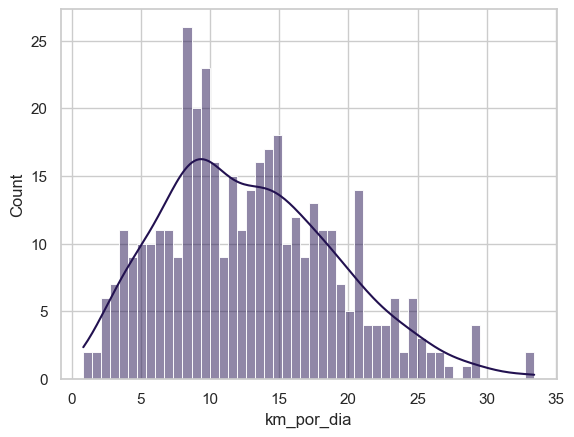

In [68]:
sns.histplot(df_distance["km_por_dia"], bins=50, kde=True);


## KMean

### Encontrar _k_ óptimo

In [74]:
X = new_df[["AvgLatitude", "AvgLongitude", "TotalDistance"]]

In [75]:
kmeans_per_k = [KMeans(n_clusters=k, n_init=150, random_state=10).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [76]:
df_kmeans = pd.DataFrame(inertias, columns=['inertia'])
df_kmeans['inertia_1'] = df_kmeans['inertia'].shift(1)
df_kmeans['diff%'] = df_kmeans['inertia']/df_kmeans['inertia_1']
df_kmeans

,inertia,inertia_1,diff%
0,3.122698e+09,NaN,NaN
1,1.196628e+09,3.122698e+09,0.383203
2,7.049222e+08,1.196628e+09,0.589090
3,4.516959e+08,7.049222e+08,0.640774
4,2.840642e+08,4.516959e+08,0.628884
5,1.881384e+08,2.840642e+08,0.662309
6,1.304340e+08,1.881384e+08,0.693288
7,1.009016e+08,1.304340e+08,0.773584
8,7.376964e+07,1.009016e+08,0.731105


Text(0, 0.5, 'Inertia')

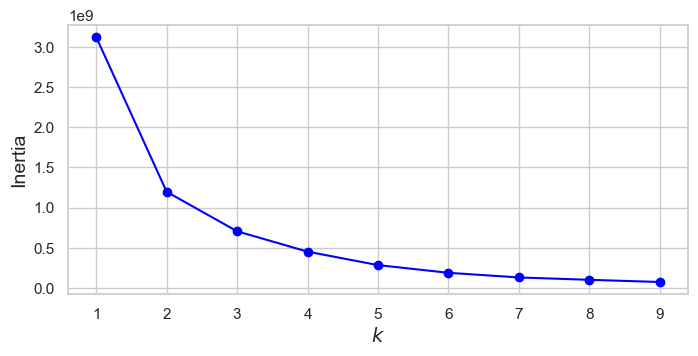

In [77]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

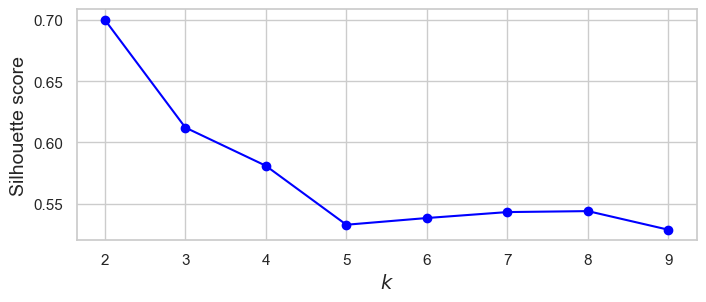

In [78]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
# plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

In [79]:
silhouette_scores

[np.float64(0.7002779041747227),
 np.float64(0.6122005688234665),
 np.float64(0.5809367953714158),
 np.float64(0.5327538512384375),
 np.float64(0.5382468708729009),
 np.float64(0.5431030402257564),
 np.float64(0.543891641052001),
 np.float64(0.5286606666204882)]

In [80]:
# Cluster the bears using k-means
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(new_df[["AvgLatitude", "AvgLongitude", "TotalDistance"]])
# Add the cluster labels to the dataframe
new_df["Cluster"] = clusters

In [81]:
new_df.head()

,UniqueAnimalID,AvgLatitude,AvgLongitude,TotalDistance,Cluster
0,1,70.253606,-143.775609,1255.087194,3
1,3,72.124187,-143.758874,2694.620502,0
2,4,71.306492,-145.272690,4294.946165,0
3,5,70.229404,-143.898422,12597.408190,1
4,10,73.298487,-148.668127,5445.447921,4


In [82]:
new_df.shape

(406, 5)

## Analyze female polar bear behaviour

In [83]:
cluster_summary = new_df.groupby("Cluster").agg(
    {"UniqueAnimalID": "count",
     "AvgLatitude": "mean",
     "AvgLongitude": "mean",
     "TotalDistance": "mean"
    }
)
# Print the summary statistics for each cluster
print(cluster_summary)

         UniqueAnimalID  AvgLatitude  AvgLongitude  TotalDistance
Cluster                                                          
0                   147    72.606180   -111.728351    3567.891512
1                    17    73.188471   -128.953422   11579.348808
2                     1    71.995771   -143.345428   26299.811749
3                   187    71.849195    -91.626041    1686.623266
4                    54    72.743135   -139.308226    6811.841785


Mostrar perfiles por cluster con km/dia promedio en lugar del total

In [84]:
df_cluster_summary = new_df.merge(df_distance[["km_por_dia"]], on="UniqueAnimalID")
resumen_cluster = df_cluster_summary.groupby("Cluster").agg(
    osas=("UniqueAnimalID", "count"),
    km_dia_mean=("km_por_dia", "mean"),
    km_dia_std=("km_por_dia", "std"),
    latitud_prom=("AvgLatitude", "mean")
).reset_index()


Esto da un panorama mucho más realista y permitiría responder con confianza a preguntas como: "¿Hay grupos que se mueven más por día? ¿Existen diferencias latitudinales consistentes?"

In [94]:
resumen_cluster.sort_values(by='km_dia_mean', ascending =False)

,Cluster,osas,km_dia_mean,km_dia_std,latitud_prom
0,0,147,16.282671,7.605643,72.606180
3,3,187,11.756655,4.277620,71.849195
4,4,54,9.267537,3.438286,72.743135
1,1,17,7.314145,3.224811,73.188471
2,2,1,4.150854,NaN,71.995771


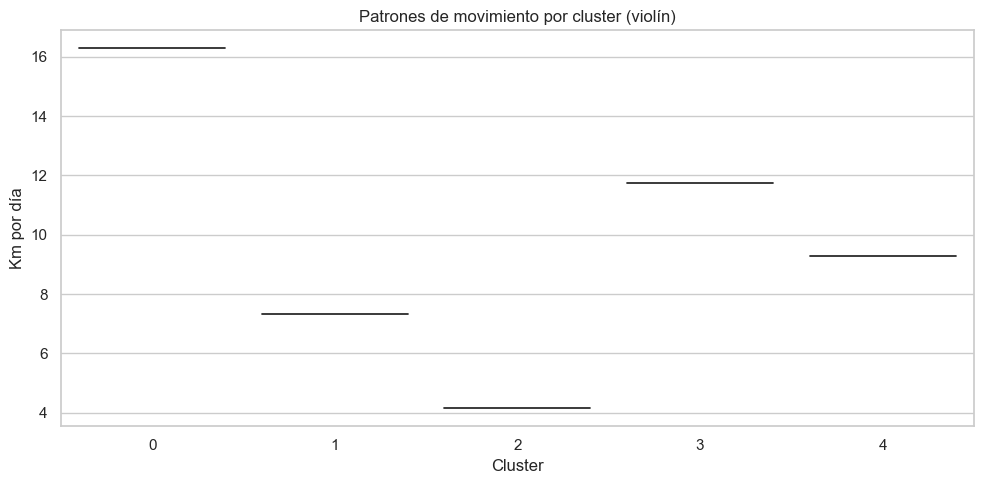

In [96]:
plt.figure(figsize=(10, 5))
sns.violinplot(data=resumen_cluster, x="Cluster", y="km_dia_mean", palette="magma", inner="quartile")
plt.title("Patrones de movimiento por cluster (violín)")
plt.xlabel("Cluster")
plt.ylabel("Km por día")
plt.tight_layout()
plt.show()


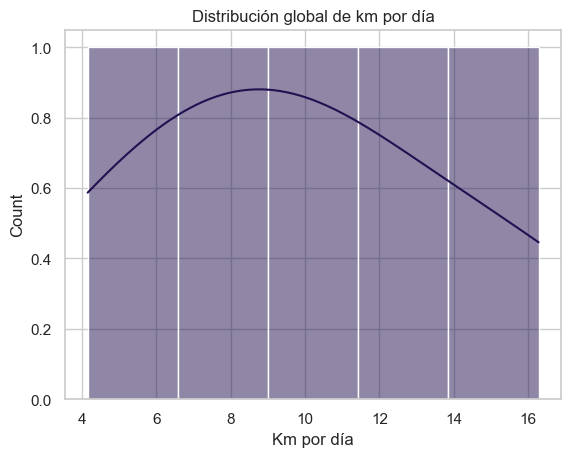

In [98]:
sns.histplot(resumen_cluster["km_dia_mean"], bins=5, kde=True)
plt.title("Distribución global de km por día")
plt.xlabel("Km por día")
plt.show()


In [25]:
new_df.head()

,UniqueAnimalID,AvgLatitude,AvgLongitude,TotalDistance,Cluster
0,1,70.253606,-143.775609,1255.087194,1
1,3,72.124187,-143.758874,2694.620502,1
2,4,71.306492,-145.272690,4294.946165,0
3,5,70.229404,-143.898422,12597.408190,4
4,10,73.298487,-148.668127,5445.447921,0


In [26]:
# Cargar DataFrame
# new_df debe tener columnas: AvgLatitude, AvgLongitude, Cluster, UniqueAnimalID, TotalDistance
# new_df = pd.read_csv("polar_bears_summary.csv")

# Paleta de colores por clúster
cluster_colors = {
    0: "red",
    1: "blue",
    2: "green",
    3: "orange",
    4: "purple"
}

# Crea el mapa base
m = Map(center=(75, -95), zoom=3, basemap=basemaps.OpenStreetMap.Mapnik)

# Crea los marcadores
markers = []
for _, row in new_df.iterrows():
    color = cluster_colors.get(row["Cluster"], "gray")
    html = HTML()
    html.value = f"""
    <b>{row['UniqueAnimalID']}</b><br>
    Cluster: {row['Cluster']}<br>
    Distancia: {row['TotalDistance']} km
    """
    marker = Marker(location=(row["AvgLatitude"], row["AvgLongitude"]),
                    draggable=False,
                    icon_kwargs={"color": color})
    marker.popup = html
    markers.append(marker)

# Agrupa en clúster
marker_cluster = MarkerCluster(markers=markers)
m.add_layer(marker_cluster)

m


Map(center=[75, -95], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

In [47]:
from ipyleaflet import Map, CircleMarker, MarkerCluster, basemaps
from ipywidgets import HTML
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#  `new_df` con AvgLatitude, AvgLongitude, TotalDistance, UniqueAnimalID
# Normalizar TotalDistance para colores y tamaños
distancias = new_df["TotalDistance"]
# norm = colors.Normalize(vmin=distancias.min(), vmax=distancias.max())
# colormap = cm.get_cmap("plasma")
# Normaliza la escala
norm = colors.Normalize(vmin=new_df["TotalDistance"].min(), vmax=new_df["TotalDistance"].max())
colormap_func = cm.get_cmap("viridis")  # o viridis, inferno, plasma...

# def distancia_a_color(dist):
#     rgba = colormap(norm(dist))
#     return f"rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, 0.7)"

def distancia_a_color(dist):
    rgba = colormap_func(norm(dist))
    r, g, b = [int(x * 255) for x in rgba[:3]]  # ignora el alpha original
    return f"rgba({r}, {g}, {b}, 0.7)"

def distancia_a_radio(dist):
    return 5 + (norm(dist) * 15)  # tamaño mínimo 5, máximo 20

# Crear el mapa
m = Map(center=(75, -95), zoom=3, basemap=basemaps.OpenStreetMap.Mapnik)

# Crear marcadores
marcadores = []
for _, row in new_df.iterrows():
    color = distancia_a_color(row["TotalDistance"])
    radio = distancia_a_radio(row["TotalDistance"])
    
    popup = HTML()
    popup.value = f"""
    <b>{'Bear Id:' + str(int(row['UniqueAnimalID']))}</b><br>
    Distancia: {row['TotalDistance']:.1f} km
    """

    marcador = CircleMarker()
    marcador.location = (row["AvgLatitude"], row["AvgLongitude"])
    marcador.radius = int(radio)
    marcador.color = color
    marcador.fill_color = color
    marcador.fill_opacity = 0.8
    marcador.popup = popup
    # marcador.draggable=True
    # marcador.zoom_control=True
    # marcador.world_copy_jump=True

    marcadores.append(marcador)


### Leyenda visual del color (_TotalDistance_)

In [48]:
# Agrupar en cluster y mostrar
import branca.colormap as bcm

# Creamos una escala del mismo rango que usamos para colorear
colormap = bcm.LinearColormap(
    colors=["blue", "lime", "yellow", "red"],
    vmin=new_df["TotalDistance"].min(),
    vmax=new_df["TotalDistance"].max(),
    caption="Distancia total recorrida (km)"
)

m.add_control(colormap)  # Esto añade la leyenda al mapa

cluster = MarkerCluster(markers=marcadores)
m.add_layer(cluster)
m


Map(center=[75, -95], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

In [29]:
new_df.head()

,UniqueAnimalID,AvgLatitude,AvgLongitude,TotalDistance,Cluster
0,1,70.253606,-143.775609,1255.087194,1
1,3,72.124187,-143.758874,2694.620502,1
2,4,71.306492,-145.272690,4294.946165,0
3,5,70.229404,-143.898422,12597.408190,4
4,10,73.298487,-148.668127,5445.447921,0


### Cálculo de _StepsLength_ a partir de coordenadas consecutivas

In [30]:
#  Asegurar el orden temporal por individuo
df_raw = df_raw.sort_values(["UniqueAnimalID", "timestamp"])

from geopy.distance import geodesic

# Calculamos desplazamientos paso a paso por oso
def calcular_step_lengths(sub_df):
    '''
        Calcular _StepLength_ en kilómetros
    '''
    pasos = []
    coords = list(zip(sub_df["mu_lat"], sub_df["mu_lon"]))
    for i in range(1, len(coords)):
        d = geodesic(coords[i-1], coords[i]).kilometers
        pasos.append(d)
    # Añade un 0 al principio para que tenga el mismo número de filas
    pasos.insert(0, 0.0)
    return pasos

df_raw["StepLength"] = df_raw.groupby("UniqueAnimalID").apply(calcular_step_lengths).explode().astype(float).values

df_raw.groupby("UniqueAnimalID")["StepLength"].sum()



UniqueAnimalID
1       1260.018349
3       2705.176127
4       4311.390758
5      12646.833579
10      5466.987751
           ...     
536     3820.979929
537     1340.958449
539     2322.372371
540     1260.193080
541     4880.747386
Name: StepLength, Length: 406, dtype: float64

In [31]:
new_df.head()

,UniqueAnimalID,AvgLatitude,AvgLongitude,TotalDistance,Cluster
0,1,70.253606,-143.775609,1255.087194,1
1,3,72.124187,-143.758874,2694.620502,1
2,4,71.306492,-145.272690,4294.946165,0
3,5,70.229404,-143.898422,12597.408190,4
4,10,73.298487,-148.668127,5445.447921,0


In [32]:
df_cluster = new_df.copy()

### Slider para filtrar por año

In [33]:
df_raw["Year"] = pd.to_datetime(df_raw["timestamp"]).dt.year

avg_lat_lon_year = df_raw.groupby(["UniqueAnimalID", "Year"])[["mu_lat", "mu_lon"]].mean()
total_distance_year = df_raw.groupby(["UniqueAnimalID", "Year"])["StepLength"].sum()

new_df = pd.DataFrame({
    "UniqueAnimalID": avg_lat_lon_year.index.get_level_values(0),
    "Year": avg_lat_lon_year.index.get_level_values(1),                 # < --------------------- amplio
    "AvgLatitude": avg_lat_lon_year["mu_lat"].values,
    "AvgLongitude": avg_lat_lon_year["mu_lon"].values,
    "TotalDistance": total_distance_year.values
})


In [34]:
import ipywidgets as widgets
from IPython.display import display

slider = widgets.IntSlider(
    value=new_df["Year"].min(),
    min=new_df["Year"].min(),
    max=new_df["Year"].max(),
    step=1,
    description="Año:"
)

# Contenedor para regenerar el mapa
output_map = widgets.Output()

def actualizar_mapa(cambio):
    output_map.clear_output()
    with output_map:
        # Filtra por año
        df_filtrado = new_df[new_df["Year"] == slider.value]

        # Genera nuevos marcadores (como hicimos antes)
        marcadores = []
        for _, row in df_filtrado.iterrows():
            color = distancia_a_color(row["TotalDistance"])
            radio = distancia_a_radio(row["TotalDistance"])
            popup = HTML()
            popup.value = f"<b>{row['UniqueAnimalID']}</b><br>Distancia: {row['TotalDistance']:.1f} km"
            marcador = CircleMarker(location=(row["AvgLatitude"], row["AvgLongitude"]),
                                    radius=int(radio), color=color, fill_color=color, fill_opacity=0.8,
                                    popup=popup)
            marcadores.append(marcador)

        cluster = MarkerCluster(markers=marcadores)
        new_map = Map(center=(75, -95), zoom=3, basemap=basemaps.OpenStreetMap.Mapnik)
        new_map.add_layer(cluster)
        new_map.add_control(colormap)
        display(new_map)

slider.observe(actualizar_mapa, names="value")
display(slider, output_map)

# Inicializa
actualizar_mapa(None)


IntSlider(value=1985, description='Año:', max=2017, min=1985)

Output()

In [35]:
df_raw.groupby('Year')['UniqueAnimalID'].nunique().sort_values(ascending=False)

Year
2009    48
1993    43
1992    42
2008    38
1990    30
1988    29
1989    28
2011    27
2004    27
1991    25
2010    25
2005    20
2006    19
2015    18
2007    17
1987    16
2002    16
2013    16
2000    16
1999    16
2001    15
1986    13
2017    13
2014    12
2003     9
2016     9
2012     8
1994     6
1998     6
1995     3
1985     2
Name: UniqueAnimalID, dtype: int64

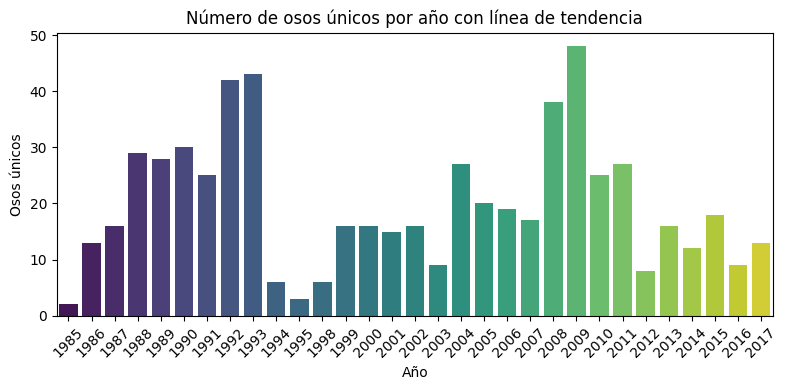

In [36]:
plt.figure(figsize=(8, 4))
sns.barplot(df_raw.groupby('Year')['UniqueAnimalID'].nunique(), palette='viridis')
plt.xticks(rotation=30)
plt.title('Número de osos únicos por año con línea de tendencia')
plt.ylabel('Osos únicos')
plt.xlabel('Año')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

### Capa dinámica de hielo marino

#### Carga y preprocesamiento de CDR de hielo marino

#### Función que genera una imagen PNG por año (como overlay)

In [37]:
from ipyleaflet import ImageOverlay
from matplotlib import cm
import xarray as xr
import numpy as np
from PIL import Image
import io
import base64
import pandas as pd

def generar_overlay_ice(year, month=9):
    # Dataset ERDDAP (NOAA/NSIDC CDR V5 mensual hemisferio norte)
    url = 'https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nh1day'

    try:
        # Abrimos el dataset remoto
        ds = xr.open_dataset(url)

        # Aseguramos formato datetime
        ds["time"] = pd.to_datetime(ds["time"].values)

        # Seleccionamos la fecha más cercana al primer día del mes y año
        fecha_objetivo = pd.Timestamp(f"{year}-{month:02d}-01")
        da = ds["cdr_seaice_conc"].sel(time=fecha_objetivo, method="nearest")

        # Datos crudos
        ice = da.values
        ice_norm = np.clip(ice / 100.0, 0, 1)

        # Aplicamos colormap
        # rgba = (cm.get_cmap("Blues_r")(ice_norm) * 255).astype(np.uint8)
        rgba = (cm.get_cmap("viridis")(ice_norm) * 255).astype(np.uint8)
        img = Image.fromarray(rgba, mode="RGBA")

        # Convertimos a base64 en memoria
        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        img_b64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
        img_url = f"data:image/png;base64,{img_b64}"

        # Coordenadas del grid
        # lat_min, lat_max = float(ds["latitude"].min()), float(ds["latitude"].max())
        # lon_min, lon_max = float(ds["longitude"].min()), float(ds["longitude"].max())
        # bounds = [lat_min, lon_min, lat_max, lon_max]
        # Usamos límites fijos para el Ártico si no hay lat/lon en el dataset
        bounds = [40.0, -180.0, 90.0, 180.0]

        return ImageOverlay(url=img_url, bounds=bounds, opacity=0.4)

    except Exception as e:
        print(f"⚠️ Error al generar overlay para {year}-{month:02d}: {e}")
        return None


#### Integrarlo en el slider junto al mapa y marcadores

In [38]:
# Añadir overlay de hielo
overlay = generar_overlay_ice(slider.value)
new_map.add_layer(overlay)


⚠️ Error al generar overlay para 1985-09: [Errno -68] NetCDF: I/O failure: 'https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nh1day'


NameError: name 'new_map' is not defined

In [ ]:
import ipywidgets as widgets
from ipyleaflet import Map, LayersControl
from IPython.display import display

# Lista de años quinquenales disponibles
años = list(range(1985, 2025, 5))  # 1985, 1985, ..., 2020

# Crear slider
slider = widgets.IntSlider(
    value=años[0],
    options=años,
    min=min(años),
    max=max(años),
    step=5,
    description="Año:",
    style={"description_width": "60px"}
)

# Crear mapa base
m = Map(center=(75, -95), zoom=3)
m.add_control(LayersControl(position="topright"))

# Contenedor de overlay actual
overlay_actual = [None]

# Función que actualiza el mapa con el overlay correspondiente
def on_slider_change(change):
    year = change["new"]

    # Eliminar overlay anterior si existe
    if overlay_actual[0]:
        m.remove_layer(overlay_actual[0])

    # Generar nuevo overlay dinámico
    overlay_nuevo = generar_overlay_ice(year)
    if overlay_nuevo:
        m.add_layer(overlay_nuevo)
        overlay_actual[0] = overlay_nuevo
    else:
        print(f"No se pudo generar overlay para {year}")

# Vincular cambio de slider
slider.observe(on_slider_change, names="value")

from ipyleaflet import GeoJSON
import json
import requests

# Capa de países para orientación
url_geojson = "https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json"
data_geojson = requests.get(url_geojson).json()

# Añadir capa al mapa
capa_paises = GeoJSON(data=data_geojson, style={'color': 'gray', 'fillOpacity': 0})
m.add_layer(capa_paises)


# Mostrar todo
display(slider, m)
on_slider_change({"new": slider.value})  # inicializar con primer año


IntSlider(value=1985, description='Año:', max=2020, min=1985, step=5, style=SliderStyle(description_width='60p…

Map(center=[75, -95], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

### Female Polar Bear Average location

In [ ]:
cluster_summary

,UniqueAnimalID,AvgLatitude,AvgLongitude,TotalDistance
Cluster,,,,
0,117,72.578078,-107.664005,3903.999562
1,14,73.311830,-133.003347,12065.587595
2,223,72.001851,-97.927361,1861.995919
3,1,71.995771,-143.345428,26299.811749
4,51,72.682897,-136.793189,7130.504398


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import io
import base64
import ipywidgets as widgets
from ipyleaflet import WidgetControl

def crear_leyenda_magma(min_val, max_val):
    # Crear figura horizontal
    fig, ax = plt.subplots(figsize=(4, 0.4))
    cmap = plt.get_cmap("magma")
    norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
    cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')

    ax.set_title('Cluster ID', fontsize=10)
    cb.set_ticks(range(min_val, max_val + 1))
    cb.ax.tick_params(labelsize=8)

    # Guardar como imagen base64
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight', dpi=100)
    plt.close(fig)
    img_b64 = base64.b64encode(buffer.getvalue()).decode('utf-8')
    return img_b64


In [ ]:
from ipyleaflet import Map, CircleMarker, LayerGroup, WidgetControl
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import ipywidgets as widgets
import numpy as np

def mostrar_ositas_cluster(cluster_summary):
    m = Map(
        center=(83, -40),
        zoom=1.3,
        scroll_wheel_zoom=True,
        dragging=True,
        zoom_control=False,
        world_copy_jump=True
    )

    # Asegurar columnas en minúsculas
    cluster_summary.columns = cluster_summary.columns.str.lower()
    cluster_summary = cluster_summary.reset_index()  # asegurar que 'cluster' sea columna

    # Elegimos un colormap más alegre 
    cmap = cm.get_cmap("magma", len(cluster_summary))
    norm = mcolors.Normalize(vmin=0, vmax=len(cluster_summary) - 1)

    # Escalado del radio en función de uniqueanimalid
    min_count = cluster_summary["uniqueanimalid"].min()
    max_count = cluster_summary["uniqueanimalid"].max()

    # Crear marcadores con colores y tamaños por cluster
    marcadores = []
    leyenda_items = []

    for i, row in cluster_summary.iterrows():
        cluster_id = row["cluster"]
        lat = row["avglatitude"]
        lon = row["avglongitude"]
        count = row["uniqueanimalid"]

        color = mcolors.to_hex(cmap(norm(i)))
        radius = np.interp(count, (min_count, max_count), (1, 8))

        marcador = CircleMarker(
            location=(lat, lon),
            radius=int(radius),
            color=color,
            fill_color=color,
            fill_opacity=0.75
        )
        marcadores.append(marcador)

        leyenda_items.append(
            f"<div style='color:{color}; font-size:14px; line-height:1.4;'><b>■</b>🐾 Cluster {cluster_id} ({count} osas)</div>"
        )

    # Añadir capa al mapa
    m.add_layer(LayerGroup(layers=marcadores))

    # Crear leyenda con HTML estilizado
    # leyenda_html = widgets.HTML(
    #     "<div style='padding: 8px; background-color: white; border:1px solid #ccc;'>"
    #     "<b>🐾 Clusters de osas polares:</b><br>" + "<br>".join(leyenda_items) + "</div>"
    # )
    # leyenda = WidgetControl(widget=leyenda_html, position="bottomright")
    # m.add_control(leyenda)

    # Rango de cluster IDs
    min_cluster = int(cluster_summary["cluster"].min())
    max_cluster = int(cluster_summary["cluster"].max())

    # Crear imagen de leyenda
    img_b64 = crear_leyenda_magma(min_cluster, max_cluster)
    leyenda_img = widgets.HTML(
        value=f"<img src='data:image/png;base64,{img_b64}' style='width:250px;'>"
    )
    leyenda_widget = WidgetControl(widget=leyenda_img, position='bottomright')
    m.add_control(leyenda_widget)


    return m


In [ ]:
# from ipyleaflet import Map, CircleMarker, LayerGroup
# import matplotlib.cm as cm
# import matplotlib.colors as mcolors

# def mostrar_ositas_cluster(df):
#     # Usamos un centro más alto y vista extendida del Ártico
#     m = Map(center=(83, -60), zoom=2.5, scroll_wheel_zoom=True)

#     # Asegurar nombres de columnas en minúsculas
#     df.columns = df.columns.str.lower()

#     # Preparar colormap viridis
#     cluster_ids = df["cluster"].unique()
#     n_clusters = len(cluster_ids)
#     cmap = cm.get_cmap("viridis", n_clusters)
#     norm = mcolors.Normalize(vmin=0, vmax=n_clusters - 1)
#     colores = {
#         cid: mcolors.to_hex(cmap(norm(i))) for i, cid in enumerate(cluster_ids)
#     }

#     marcadores = []
#     for _, row in df.iterrows():
#         color = colores[row["cluster"]]
#         marcador = CircleMarker(
#             location=(row["avglatitude"], row["avglongitude"]),
#             radius=5,
#             color=color,
#             fill_color=color,
#             fill_opacity=0.8
#         )
#         marcadores.append(marcador)

#     m.add_layer(LayerGroup(layers=marcadores))
#     return m


In [ ]:
df_cluster.head()

,uniqueanimalid,avglatitude,avglongitude,totaldistance,cluster
0,1,70.253606,-143.775609,1255.087194,2
1,3,72.124187,-143.758874,2694.620502,2
2,4,71.306492,-145.272690,4294.946165,0
3,5,70.229404,-143.898422,12597.408190,1
4,10,73.298487,-148.668127,5445.447921,0


In [ ]:
mostrar_ositas_cluster(df_cluster)

Map(center=[83, -40], controls=(AttributionControl(options=['position', 'prefix'], position='bottomright'), Wi…

In [143]:
new_df.columns

Index(['UniqueAnimalID', 'Year', 'AvgLatitude', 'AvgLongitude',
       'TotalDistance'],
      dtype='object')

## k 2 5 vs 8

In [52]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from ipyleaflet import Map, CircleMarker, LayerGroup
from ipywidgets import VBox, Label
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

def mapa_clusters_con_centroides(df, cluster_summary, k=5, cmap="magma"):
    df = df.copy()
    df.columns = df.columns.str.lower()
    cluster_summary.columns = cluster_summary.columns.str.lower()

    # Normalizar variables
    X = df[["avglatitude", "avglongitude", "totaldistance"]]
    X_scaled = StandardScaler().fit_transform(X)

    # Clustering
    modelo = KMeans(n_clusters=k, random_state=42, n_init='auto')
    df["cluster"] = modelo.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, df["cluster"])

    # Mapa base
    m = Map(center=(83, -40), zoom=1.3, scroll_wheel_zoom=True,
            dragging=True, world_copy_jump=True, zoom_control=False)

    # Colores
    cluster_ids = sorted(df["cluster"].unique())
    cmap_k = cm.get_cmap(cmap, len(cluster_ids))
    norm = mcolors.Normalize(vmin=0, vmax=len(cluster_ids) - 1)
    colores = {cid: mcolors.to_hex(cmap_k(norm(i))) for i, cid in enumerate(cluster_ids)}

    # Marcadores por osa
    marcadores = []
    for _, row in df.iterrows():
        color = colores[row["cluster"]]
        marcador = CircleMarker(
            location=(row["avglatitude"], row["avglongitude"]),
            radius=5,
            color=color,
            fill_color=color,
            fill_opacity=0.75
        )
        marcadores.append(marcador)
    m.add_layer(LayerGroup(layers=marcadores))
    
    # Centroides
    for _, row in cluster_summary.iterrows():
        marcador_centroide = CircleMarker(
            location=(row["avglatitude"], row["avglongitude"]),
            radius=9,
            color="red",
            fill_color="white",
            fill_opacity=1.0
        )
        m.add_layer(marcador_centroide)

    # Título
    titulo = f"Clustering k = {k}  (Silhouette = {sil:.2f})"
    return VBox([Label(titulo), m])

In [53]:
mapa = mapa_clusters_con_centroides(new_df, cluster_summary, k=5)
display(mapa)


In [49]:
new_df

,UniqueAnimalID,Year,AvgLatitude,AvgLongitude,TotalDistance
0,1,1986,70.253606,-143.775609,1260.018349
1,3,1985,71.681196,-144.766673,1436.456665
2,3,1986,72.559482,-142.768586,1268.719461
3,4,1988,70.639825,-139.355941,1967.025357
4,4,1990,71.981988,-151.267807,2344.365401
...,...,...,...,...,...
607,537,2008,70.224561,-141.914127,1340.958449
608,539,2009,73.351601,-141.061006,2322.372371
609,540,2009,70.225662,-144.872988,1260.193080
610,541,2006,73.918563,-154.491837,2517.827147


In [55]:
cluster_summary

,uniqueanimalid,avglatitude,avglongitude,totaldistance
Cluster,,,,
0,117,72.578078,-107.664005,3903.999562
1,223,72.001851,-97.927361,1861.995919
2,52,72.668226,-137.353071,7179.767738
3,1,71.995771,-143.345428,26299.811749
4,13,73.418891,-130.472294,12248.156017


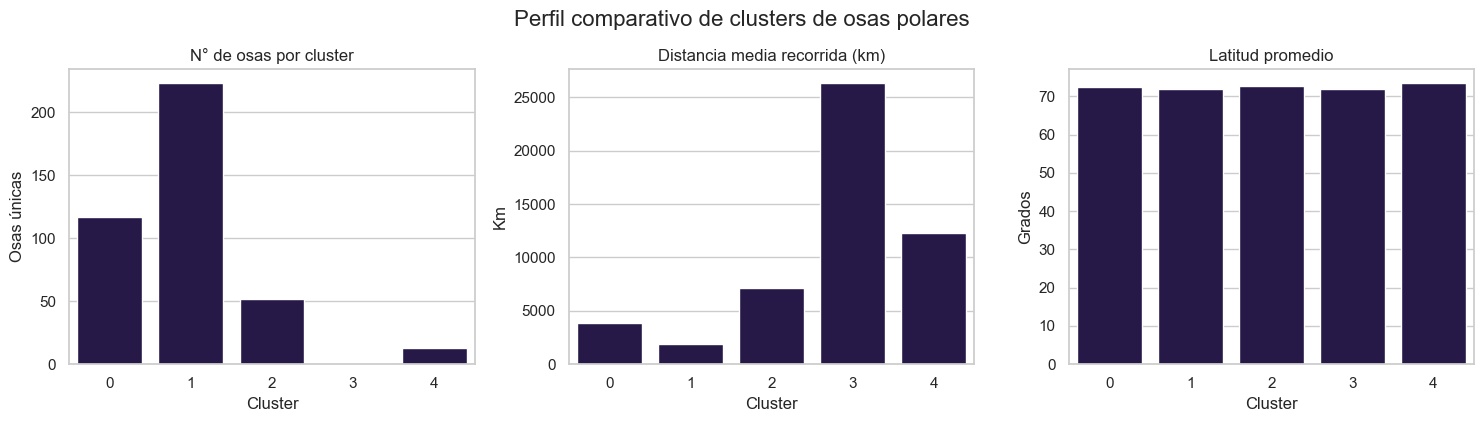

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegura nombres en minúsculas
cluster_summary_plot = cluster_summary.copy()
cluster_summary_plot.columns = cluster_summary_plot.columns.str.lower()
cluster_summary_plot = cluster_summary_plot.reset_index()

# Ordenar por TotalDistance si lo deseas
cluster_summary_plot = cluster_summary_plot.sort_values("totaldistance", ascending=False)

# Estilo de Seaborn
sns.set(style="whitegrid", palette="magma")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Número de osas
sns.barplot(data=cluster_summary_plot, x="Cluster", y="uniqueanimalid", ax=axes[0])
axes[0].set_title("N° de osas por cluster")
axes[0].set_ylabel("Osas únicas")

# 2. Distancia media recorrida
sns.barplot(data=cluster_summary_plot, x="Cluster", y="totaldistance", ax=axes[1])
axes[1].set_title("Distancia media recorrida (km)")
axes[1].set_ylabel("Km")

# 3. Latitud media
sns.barplot(data=cluster_summary_plot, x="Cluster", y="avglatitude", ax=axes[2])
axes[2].set_title("Latitud promedio")
axes[2].set_ylabel("Grados")

# Ajustes finales
for ax in axes:
    ax.set_xlabel("Cluster")

plt.tight_layout()
plt.suptitle("Perfil comparativo de clusters de osas polares", fontsize=16, y=1.05)
plt.show()


<Axes: xlabel='TotalDistance', ylabel='Count'>

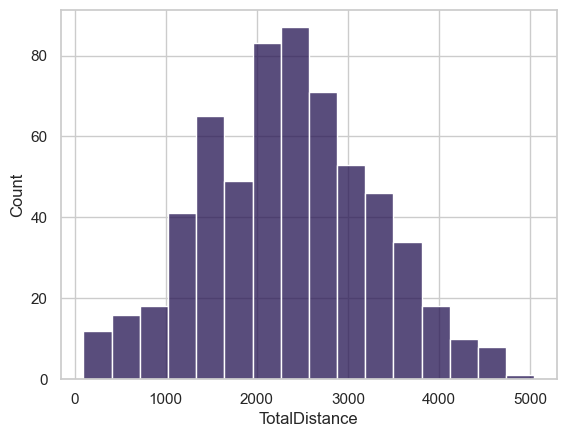

In [57]:
sns.histplot(new_df.TotalDistance)

In [58]:
# ¿Hay alguna osa que tenga más de 10,000 km?
new_df.sort_values("TotalDistance", ascending=False).head(10)


,UniqueAnimalID,Year,AvgLatitude,AvgLongitude,TotalDistance
519,440,2012,74.695497,-138.285557,5045.724956
445,370,2011,77.189283,-17.761438,4735.692104
529,451,2014,72.365937,-146.484660,4509.030580
526,447,2013,73.533605,-152.678465,4497.533096
311,292,1999,73.694915,-150.586254,4481.300636
594,529,2013,71.185412,-141.694451,4476.154035
468,388,2009,72.600346,-153.054334,4463.659057
524,444,2014,73.113470,-155.780934,4438.528744
428,360,2007,73.445754,-135.796013,4438.400995
331,300,2008,75.357527,-151.414796,4403.301635
